# Realisation method for system identification of state-space models

In this notebook, we provide a basic, minimal example of system identification using the realisation method.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
np.random.seed(5206)

## Load dataset

In this simple problem, we consider a forced pendulum

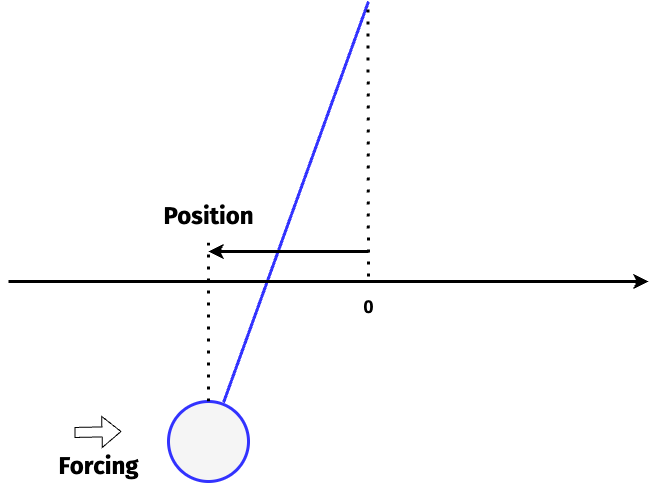

Here, the forcing is a horizontal applied force (e.g. a fan blowing at the pendulum) and the output is the pendulum's horizontal position as a function of time.

The pendulum is configured as follows:

In [2]:
m = 1 # mass (kg)
L = 1 # length of the string (m)
g = 9.81  # gravity (m/s^2)

We first load the forcing (input) and position (output) data

In [3]:
forcings, positions = np.load("./data/p2_pendulum_data.npy")

In [4]:
forcings.shape, positions.shape

((2048, 500), (2048, 500))

As seen, each is a tensor of dimension two
- The first dimension is the number of trajectories
- The second dimension is the number of time steps (here dt = 0.01 s)

In [5]:
dt = 0.01  # time step (s)
nt = forcings.shape[1]  # number of time steps
T_max = nt * dt  # final time (s)
t = np.linspace(0, T_max, nt)  # time grid (s)

Let us plot some visualisations of the input output data

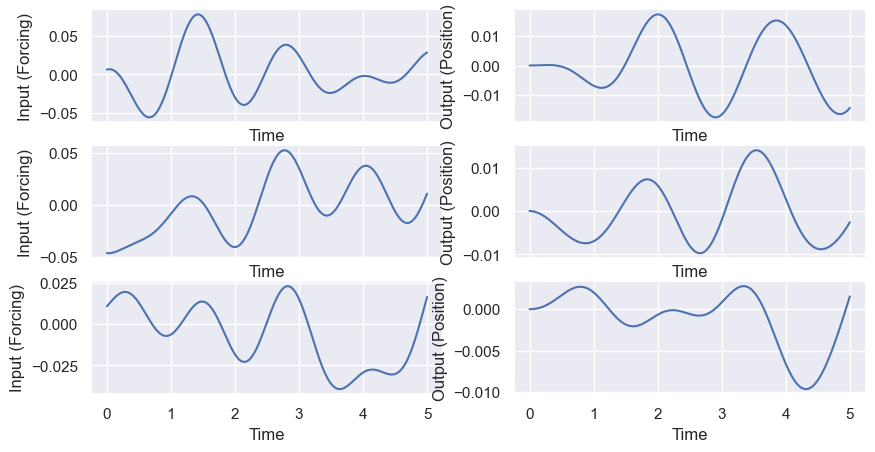

In [6]:
num_plots = 3

fig, axs = plt.subplots(num_plots, 2, figsize=(10, 5), sharex=True)

for i in range(num_plots):

    # Inputs
    axs[i, 0].plot(t, forcings[i])
    axs[i, 0].set_ylabel("Input (Forcing)")
    axs[i, 0].set_xlabel("Time")

    # Outputs
    axs[i, 1].plot(t, positions[i])
    axs[i, 1].set_ylabel("Output (Position)")
    axs[i, 1].set_xlabel("Time")

## Identification of a state-space model

Let us now provide a rough implementation of identifying a state-space model for this dataset.

In other words, we set
- $x(t)$ as the forcings (input dimension $n=1$)
- $y(t)$ as the positions (output dimension $p=1$)

and find SSM matrices
- $A \in \R^{m\times m}$
- $B \in \R^{m\times 1}$
- $C \in \R^{1\times m}$
- $D \in \R^{1\times 1}$

where $m$ is the (unknown) state space dimension and
$$
    \begin{aligned}
        h(t+1) &= Ah(t) + Bx(t) \\
        y(t) &= Ch(t) + Dx(t)
    \end{aligned}
$$

In [7]:
n = 1  # input dimension
p = 1  # output dimension

### Data preparation

We begin by processing the data and splitting them into training and testing sets

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
x_train, x_test, y_train, y_test = train_test_split(
    forcings, positions, test_size=0.25, random_state=5206
)

### Finding the impulse response function

In order to apply the realisation method, we need to know the impulse response function $\rho$ defined by the relationship
$$
    y(t) = \sum_{s} \rho(s) x(t-s)
$$

Notice that this is a *linear* relationship, so one of the simplest method is to perform (regularised) linear regression to obtain its value.

Fix $t = T_{max}/dt$ (i.e. the last time step), and define
$$
    x_{rev}(s) = x(t-s)  \qquad \text{(time-reversed input)}
$$
Then it is not hard to see that the impulse response function satisfies
$$
    \boldsymbol{y} = \boldsymbol{\rho}^\top \boldsymbol{x_{rev}}
$$

In [10]:
x_train_reversed = x_train[:, ::-1]
x_test_reversed = x_test[:, ::-1]

y_train_last = y_train[:, -1]
y_test_last = y_test[:, -1]

Now, let us perform linear regression to recover $\boldsymbol{\rho}$.

We will use the $\ell^2$-regularised (ridge) regression provided by `sklearn.linear_model.Ridge`, which adds a $\ell^2$ penalty to the loss function
$$
    \min \| \boldsymbol{Y} - \boldsymbol{X_{rev}} \boldsymbol{\rho} \| + \alpha \| \boldsymbol{\rho} \|^2
$$

In [11]:
from sklearn.linear_model import Ridge

In [12]:
reg = Ridge(alpha=1e-3)
reg.fit(x_train_reversed, y_train_last)

Ridge(alpha=0.001)

Text(0, 0.5, '$\\rho$')

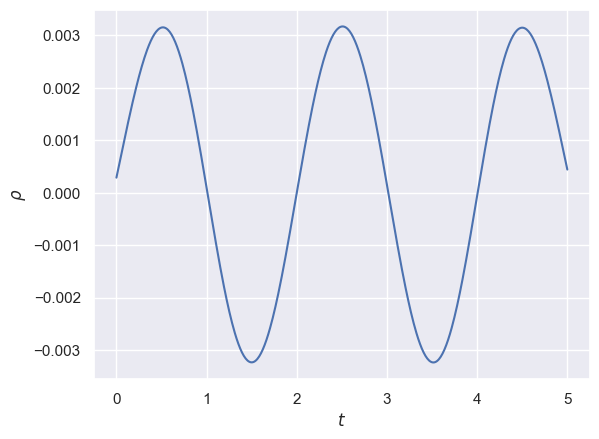

In [13]:
rho = reg.coef_
plt.plot(t, rho)
plt.xlabel(r"$t$")
plt.ylabel(r"$\rho$")

### Constructing the Hankel matrix

Next, we construct the Hankel matrix
$$
    \mathcal{H} =
    \begin{pmatrix}
        \rho(1) & \rho(2) & \cdots & \rho(l) \\
        \rho(2) & \rho(3) & \cdots & \rho(l+1) \\
        \vdots  & \vdots  & \ddots & \vdots \\
        \rho(l) & \rho(l+1) & \cdots & \rho(2l-1)
    \end{pmatrix}
$$
where $l$ is the number of look-back steps

In [14]:
l = 32  # maximum number of steps to look back

hankel_matrix = np.zeros((l, l))
for i in range(l):
    for j in range(l):
        hankel_matrix[i, j] = rho[1 + i + j]

### Constructing the observability and controllability matrices from the Hankel matrix

Recall that we can show that the Hankel matrix admits the decomposition
$$
    \mathcal{H} = O R
$$
where $O$ is the (extended) observability matrix and $R$ is the (extended) controllability matrix.

We now construct these matrix via the SVD. 

In [15]:
U, S, V_T = np.linalg.svd(hankel_matrix)

Recall that moreover, the (numerical) rank of \mathcal{H} gives an estimate of the dimension of the state-space model, i.e.
$$
    m = \text{rank} (\mathcal{H}) \approx \text{number of "non-zero" singular values}
$$

Let us plot the singular values to estimate this rank

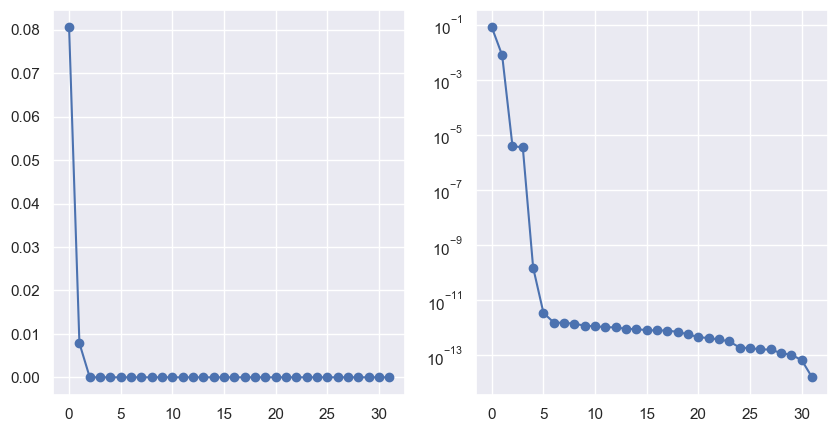

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(S, '-o')
ax[1].semilogy(S, '-o')

Observe that the first 2 singular values dominate, so we would guess that $m=2$!

In [17]:
m = 2  # hidden state dimension

We then form the controllability and observability matrices.

Recall that if
$$
    \mathcal{H} = U \Sigma V^T
$$

Then
$$
    O = U_m (\Sigma_m)^{1/2}
$$
and
$$
    R = (\Sigma_m)^{1/2} V_m^T
$$
where $U_m$ (resp. $V_m$) is the first $m$ columns of U (resp. $V$) and $\Sigma_m$ is the diagonal matrix of the first $m$ singular values

In [18]:
O = U[:, :m] @ np.diag(np.sqrt(S[:m]))
R = np.diag(np.sqrt(S[:m])) @ V_T[:m, :]

With the observability matrix, we can find read off matrix $C$

In [19]:
C = O[:p, :]

Next, we can find $A$ by the relationship that
$$
    O_2 = O_1 A 
$$
where $O_1 = O[:-1, :]$ and $O_2 = O[1:, :]$.

In [20]:
O1 = O[:-1, :]
O2 = O[1:, :]
A = np.linalg.lstsq(O1, O2, rcond=None)[0]

We can similarly find $B$ from the controllability matrix $R$, and if you'd like, you can also use a least-squares routine to find another estimate of $A$

In [21]:
B = R[:, :p]

Finally, we can read off $D$ since it is equal to $\rho(0)$

In [22]:
D = rho[0].reshape(p, n)

### Checking the learned SSM's prediction

Now, let us check the learned SSM's predictive capabilities.

In [23]:
from typing import List

class StateSpaceModel:
    """A simple discrete-time state space model.

    Attributes:
        A (numpy.ndarray): State matrix of shape (m, m).
        B (numpy.ndarray): Input matrix of shape (m, d).
        C (numpy.ndarray): Output matrix of shape (p, m).
        D (numpy.ndarray): Feedthrough matrix of shape (p, d).
        m (int): Number of states.
        d (int): Number of inputs.
        p (int): Number of outputs.
    """

    def __init__(self, A: np.ndarray, B: np.ndarray, C: np.ndarray, D: np.ndarray) -> None:
        """
        Initialize the state-space model with the given matrices.

        Parameters:
            A (numpy.ndarray): State matrix of shape (m, m).
            B (numpy.ndarray): Input matrix of shape (m, d).
            C (numpy.ndarray): Output matrix of shape (p, m).
            D (numpy.ndarray): Feedthrough matrix of shape (p, d).
        """
        # SSM matrices
        self.A = A
        self.B = B
        self.C = C
        self.D = D

        # Dimensions
        self.m = A.shape[0]
        self.d = B.shape[1]
        self.p = C.shape[0]

    def predict(self, h: np.ndarray, x: np.ndarray) -> np.ndarray:
        """
        Predict the next state given the current state and input.

        Parameters:
            h (numpy.ndarray): Current state vector of shape (m,).
            x (numpy.ndarray): Input vector of shape (d,).

        Returns:
            numpy.ndarray: Predicted state vector of shape (m,).
        """
        return self.A @ h + self.B @ x

    def output(self, h: np.ndarray, x: np.ndarray) -> np.ndarray:
        """
        Compute the output given the current state and input.

        Parameters:
            h (numpy.ndarray): Current state vector of shape (m,).
            x (numpy.ndarray): Input vector of shape (d,).

        Returns:
            numpy.ndarray: Output vector of shape (p,).
        """
        return self.C @ h + self.D @ x

    def simulate(self, xs: List[np.ndarray]) -> np.ndarray:
        """
        Simulate the state space model for a given sequence of inputs.

        Parameters:
            xs (list): List of input vectors, each of shape (d,).

        Returns:
            numpy.ndarray: Array of output vectors, each of shape (p,).
        """
        h = np.zeros(self.m)
        y = []
        for x in xs:
            y.append(self.output(h, x))
            h = self.predict(h, x)
        return np.array(y)

Let us check the prediction quality of our learned SSM

In [24]:
ssm = StateSpaceModel(A, B, C, D)

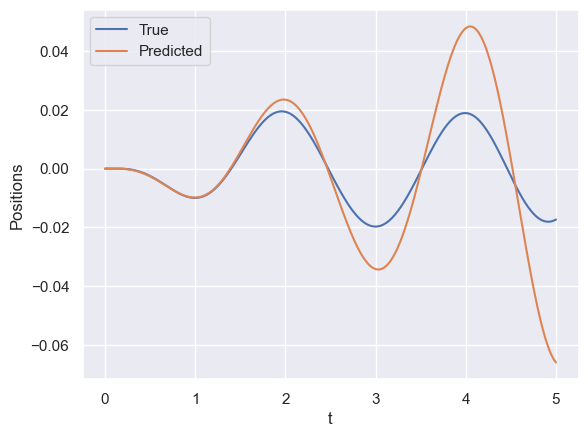

In [25]:
idx = np.random.choice(len(x_test))  # some random index
x_test_pred_ssm = ssm.simulate(xs=x_test[idx].reshape(-1, 1))

plt.plot(t, y_test[idx], label="True")
plt.plot(t, x_test_pred_ssm.ravel(), label="Predicted")
plt.xlabel('t')
plt.ylabel('Positions')
plt.legend()

## Back to physics

Now, the interesting question is: how does the identified SSM correspond to physics?

Recall from (high school?) physics that if we denote the horizontal angle of the pendulum by $\theta$,
then we have the equation for an unforced pendulum
$$
    m \frac{d^2 \theta(t)}{dt^2}
    + \frac{g}{L} \sin(\theta(t)) = 0
$$

In the case of forced dynamics we then have
$$
    m \frac{d^2 \theta(t)}{dt^2}
    + \frac{g}{L} \sin(\theta(t)) = F(t) \cos(\theta(t))
$$

In this case, the input is $x(t) = F(t)$ and the output is $y(t) = L \sin(\theta(t))$.

**Small angle approximation**

Now, this is not quite a linear model, but suppose we take a small angle approximation
$$
    \theta(t) \ll 1
$$

Then, $\sin(\theta(t)) \approx \theta(t)$ and $\cos(\theta(t)) \approx 1$, giving
$$
    m \frac{d^2 \theta(t)}{dt^2}
    + \frac{g}{L} \theta(t) \approx F(t)
$$

Finally, let us introduce the auxiliary state (angular velocity)
$$
    \omega(t) = \frac{d}{dt} \theta(t)
$$

Then, we know that this system actually *has* a (continuous-time) state-space approximation
(we take $m=1$, $L=1$ for simplicity)
$$
    \frac{d}{dt}
    \begin{pmatrix}
        \theta \\
        \omega
    \end{pmatrix}
    = 
    \begin{pmatrix}
        0 & 1 \\
        -g & 0
    \end{pmatrix}
    \begin{pmatrix}
        \theta \\
        \omega
    \end{pmatrix}
    + 
    \begin{pmatrix}
        0  \\
        1
    \end{pmatrix}
    F(t),
    \qquad
    y(t) = 
    \begin{pmatrix}
        1  \\
        0
    \end{pmatrix}^\top
    \begin{pmatrix}
        \theta \\
        \omega
    \end{pmatrix} 
$$
Going into the discrete time with a Euler discretisation,
we have the discrete-time state space representation with matrices
$$
    A = I + \delta t 
    \begin{pmatrix}
        0 & 1 \\
        -g & 0
    \end{pmatrix},
    \quad
    B = 
    \begin{pmatrix}
        0 \\
        \delta t
    \end{pmatrix}
    \quad
    C = 
    \begin{pmatrix}
        1 \\
        0
    \end{pmatrix}
    \quad
    D = 0
$$

**What about our data-driven result?**

Clearly, we have successfully identified the hidden state space dimension $m=2$!

> Now, the key question is, do we actually discover this physical representation of Newton's laws?

### The "physical" state-space representation

Let us form the physical state-space representation matrices

In [26]:
A_true = np.eye(2) + dt * np.array(
    [[0, 1.0],
    [-9.81, 0],]
)
B_true = np.array([0, dt]).reshape(2, 1)
C_true = np.array([1, 0]).reshape(1, 2)
D_true = np.array([0]).reshape(1, 1)

Now, compare with what we have learned

In [27]:
print("Learned\n", A)
print("True\n", A_true)

Learned
 [[ 1.0150387  -0.03298105]
 [ 0.03298126  0.9911244 ]]
True
 [[ 1.      0.01  ]
 [-0.0981  1.    ]]


Clearly, they are not the same!

However, recall that SSMs are actually *not unique*.

In fact, for any invertible transformation $T:\R^m \to \R^m$, the following transformations
$$
    A \mapsto T^{-1} A T \quad
    B \mapsto T^{-1} B \quad
    C \mapsto C T \quad
    D \mapsto D
$$
leaves the SSM invariant in terms of the input-output relationship it parameterises.

> Thus, we can only identify them up to these transformations!

Now, we may check if the $A$ that we identify, is equivalent to $A_{\text{true}}$ up to some similarity transform, i.e. if they have the same eigenvalues with the same multiplicity.

In [28]:
D, _ = np.linalg.eig(A)
D_true, _ = np.linalg.eig(A_true)

In [29]:
print("Learned\n", D)
print("True\n", D_true)

Learned
 [1.00308155+0.03073732j 1.00308155-0.03073732j]
True
 [1.+0.03132092j 1.-0.03132092j]


We can see that there is some reasonable agreement, although much remains to be improved!

## Exercise

- Can you think of ways to improve the accuracy of identification? What are some sources of error?
- Try this on other systems!